# Milestone 2: Regime Detection

This notebook explores regime detection using:
1. **Rule-based classification**: Hand-crafted rules based on economic thresholds
2. **HMM (Hidden Markov Model)**: Unsupervised learning of hidden market states

We'll also test our core hypothesis: **do feature-target correlations become stronger within regimes?**

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Our modules
from data.data_pipeline import DataPipeline
from regime.hmm_detector import HMMRegimeDetector
from regime.rule_based_detector import RuleBasedRegimeDetector
from regime.regime_analysis import (
    compute_regime_correlations,
    compute_regime_statistics,
    analyze_regime_transitions,
    plot_regime_overlay,
    plot_regime_comparison
)

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
plt.style.use('seaborn-v0_8-whitegrid')

print("Imports complete!")

Imports complete!


## 1. Load Data

We'll use our data pipeline to load aligned price and macro data.

In [2]:
# Load data using our pipeline
pipeline = DataPipeline()

# Get aligned data with target
features, target = pipeline.create_modeling_dataset(
    symbol='SPY',
    start_date='2020-01-01',
    end_date='2024-01-01',
    target_horizon=5,
    target_type='direction'  # Binary classification: up or down
)

# Combine for analysis
data = features.copy()
data['target'] = target

# Get price data for plotting (load separately)
price_data = pipeline.load_aligned_data(
    symbol='SPY',
    start_date='2020-01-01',
    end_date='2024-01-01',
    include_macro=False
)
data['Close'] = price_data['price_Close']

print(f"Data shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print(f"Features: {len(features.columns)}")
data.head()

Data shape: (734, 43)
Date range: 2021-02-01 00:00:00 to 2023-12-29 00:00:00
Features: 41


,price_Volume,price_Capital_Gains,price_return_1d,price_return_5d,price_return_21d,price_return_63d,price_log_return_1d,price_volatility_21d,price_volatility_63d,price_parkinson_vol_21d,price_vol_percentile,price_sma_20,price_sma_50,price_sma_200,price_close_to_sma20,price_close_to_sma50,price_close_to_sma200,price_sma_20_50_cross,price_sma_50_200_cross,price_rsi_14,price_macd,price_macd_signal,price_macd_hist,price_volume_sma_20,price_relative_volume,price_volume_change_5d,price_obv,macro_T10Y2Y,macro_VIXCLS,macro_UNRATE,macro_FEDFUNDS,macro_BAA10Y,macro_T10Y2Y_change_1m,macro_T10Y2Y_inverted,macro_VIX_percentile,macro_VIX_spike,macro_UNRATE_change_3m,macro_UNRATE_rising,macro_FEDFUNDS_change_6m,macro_BAA10Y_change_1m,macro_BAA10Y_stress,target,Close
2021-02-01,75817600.0,0.0,0.016646,-0.021228,0.011398,0.145020,0.016509,0.169939,0.146762,0.135455,0.361111,353.972546,346.838458,311.504300,-0.004896,0.015573,0.130770,1.0,1.0,47.173796,1.896161,3.191884,-1.295723,73904150.0,1.025891,0.076924,420198800.0,0.98,30.24,6.2,0.08,2.19,-0.03,0,0.837302,0,-0.5,0,-0.01,0.04,0,0,376.230011
2021-02-02,64450700.0,0.0,0.014140,-0.005837,0.020514,0.173444,0.014041,0.175750,0.146400,0.139323,0.365079,354.569864,347.339948,311.965443,0.007475,0.028446,0.145064,1.0,1.0,52.850655,2.046615,2.962830,-0.916215,71616145.0,0.899947,0.510612,484649500.0,1.01,25.56,6.2,0.08,2.18,0.00,0,0.496032,0,-0.5,0,-0.01,0.02,0,0,381.549988
2021-02-03,52427100.0,0.0,0.000786,0.019871,0.035413,0.161350,0.000786,0.167523,0.145385,0.127074,0.353175,355.062321,347.819086,312.451333,0.006869,0.027836,0.144182,1.0,1.0,52.143867,2.163571,2.802978,-0.639407,70916190.0,0.739283,-0.574977,537076600.0,1.04,22.91,6.2,0.08,2.17,0.08,0,0.257937,0,-0.5,0,-0.01,0.04,0,1,381.850006
2021-02-04,47142600.0,0.0,0.011366,0.022667,0.040018,0.154171,0.011302,0.169967,0.143234,0.126719,0.357143,355.654019,348.425170,312.997061,0.016618,0.037710,0.155169,1.0,1.0,57.570932,2.554682,2.753319,-0.198637,67873435.0,0.694566,-0.499538,584219200.0,1.04,21.77,6.2,0.08,2.19,0.05,0,0.119048,0,-0.5,0,-0.01,0.07,0,1,386.190002
2021-02-05,48669800.0,0.0,0.003936,0.047667,0.037907,0.133384,0.003929,0.169500,0.137382,0.119553,0.349206,356.057069,349.020004,313.521893,0.019465,0.040020,0.157774,1.0,1.0,62.055832,2.945527,2.791760,0.153767,66868585.0,0.727843,-0.616063,632889000.0,1.10,20.87,6.2,0.08,2.18,0.12,0,0.035714,0,-0.5,0,-0.01,0.05,0,1,387.709991


In [3]:
# Extract macro columns for regime detection
# Find macro columns (they have 'macro_' prefix)
macro_feature_cols = [c for c in data.columns if c.startswith('macro_')]
print(f"Found {len(macro_feature_cols)} macro columns")

# The base indicators we need for regime detection
base_indicators = ['T10Y2Y', 'VIXCLS', 'UNRATE', 'BAA10Y', 'FEDFUNDS']

# Create a DataFrame with original column names for detectors
macro_data = pd.DataFrame(index=data.index)
for ind in base_indicators:
    col_name = f'macro_{ind}'
    if col_name in data.columns:
        macro_data[ind] = data[col_name]
    else:
        # Try without prefix
        matching = [c for c in data.columns if ind in c]
        if matching:
            macro_data[ind] = data[matching[0]]

print("\\nMacro indicators for regime detection:")
macro_data.describe().round(2)

Found 14 macro columns
\nMacro indicators for regime detection:


,T10Y2Y,VIXCLS,UNRATE,BAA10Y,FEDFUNDS
count,734.00,734.00,734.00,734.00,734.00
mean,0.16,20.61,4.15,1.99,2.32
std,0.81,5.16,0.88,0.19,2.22
min,-1.08,12.07,3.40,1.57,0.06
25%,-0.54,16.90,3.60,1.84,0.08
50%,-0.15,19.62,3.70,1.96,1.68
75%,1.05,23.70,4.50,2.14,4.83
max,1.59,36.45,6.20,2.42,5.33


## 2. Rule-Based Regime Detection

First, let's apply our interpretable rule-based classifier. This uses economic thresholds:
- **Crisis**: VIX > 35 OR (wide spreads AND high VIX)
- **Contraction**: VIX > 25 OR yield curve inverted
- **Expansion**: Everything else (low stress indicators)

In [4]:
# Initialize rule-based detector
rule_detector = RuleBasedRegimeDetector()

# Predict regimes
rule_regimes = rule_detector.predict(macro_data)

# Get summary
rule_summary = rule_detector.get_regime_summary(macro_data)
print("Rule-Based Regime Summary:")
print(rule_summary)

Rule-Based Regime Summary:
             count  vix_mean  vix_std  yield_curve_mean  yield_curve_std  credit_spread_mean  credit_spread_std proportion
regime                                                                                                                    
Contraction    475     21.41     5.92             -0.36             0.47                2.03               0.20      64.7%
Crisis           2     35.79     0.93              0.23             0.00                2.34               0.02       0.3%
Expansion      257     19.02     2.44              1.10             0.34                1.92               0.13      35.0%


In [5]:
# Explain a few specific dates
print("=" * 60)
print("COVID Crash (March 16, 2020):")
print("=" * 60)
covid_date = '2020-03-16'
if covid_date in macro_data.index:
    print(rule_detector.explain(macro_data.loc[covid_date]))
else:
    # Find nearest date
    nearest = macro_data.index[macro_data.index.get_indexer([pd.to_datetime(covid_date)], method='nearest')[0]]
    print(f"Using nearest date: {nearest}")
    print(rule_detector.explain(macro_data.loc[nearest]))

COVID Crash (March 16, 2020):
Using nearest date: 2021-02-01 00:00:00
Regime: Contraction

Indicator values:
  VIX: 30.2 (ELEVATED)
  Yield Curve: 0.98% (NORMAL)
  Credit Spread: 2.19% (ELEVATED)

Classification reasoning:
  Contraction triggered by: VIX (30.2) > elevated threshold (25.0)


In [6]:
print("\n" + "=" * 60)
print("Bull Market (July 2021):")
print("=" * 60)
bull_date = '2021-07-15'
if bull_date in macro_data.index:
    print(rule_detector.explain(macro_data.loc[bull_date]))
else:
    nearest = macro_data.index[macro_data.index.get_indexer([pd.to_datetime(bull_date)], method='nearest')[0]]
    print(f"Using nearest date: {nearest}")
    print(rule_detector.explain(macro_data.loc[nearest]))


Bull Market (July 2021):
Regime: Expansion

Indicator values:
  VIX: 17.0 (NORMAL)
  Yield Curve: 1.08% (NORMAL)
  Credit Spread: 1.92% (TIGHT (risk-on))

Classification reasoning:
  Expansion: No stress indicators triggered
    VIX (17.0) <= 25.0
    Curve (1.08%) >= 0.0


In [7]:
print("\n" + "=" * 60)
print("Rate Hike Period (October 2022):")
print("=" * 60)
hike_date = '2022-10-15'
if hike_date in macro_data.index:
    print(rule_detector.explain(macro_data.loc[hike_date]))
else:
    nearest = macro_data.index[macro_data.index.get_indexer([pd.to_datetime(hike_date)], method='nearest')[0]]
    print(f"Using nearest date: {nearest}")
    print(rule_detector.explain(macro_data.loc[nearest]))


Rate Hike Period (October 2022):
Using nearest date: 2022-10-14 00:00:00
Regime: Contraction

Indicator values:
  VIX: 32.0 (ELEVATED)
  Yield Curve: -0.48% (INVERTED (recession signal))
  Credit Spread: 2.28% (ELEVATED)

Classification reasoning:
  Contraction triggered by: VIX (32.0) > elevated threshold (25.0); Yield curve inverted (-0.48%); Elevated spreads with flat curve


## 3. HMM Regime Detection

Now let's fit a Hidden Markov Model to learn regimes from the data.

**Key differences from rule-based:**
- HMM learns patterns from data (unsupervised)
- Captures complex, multi-dimensional relationships
- Provides probability distributions, not hard labels

In [8]:
# Initialize HMM detector with 3 regimes
hmm_detector = HMMRegimeDetector(
    n_regimes=3,
    features=['T10Y2Y', 'VIXCLS', 'UNRATE', 'BAA10Y'],
    random_state=42
)

# Fit on full data
hmm_detector.fit(macro_data, label_by_volatility=True)

# Predict regimes
hmm_regimes = hmm_detector.predict(macro_data)

# Get summary
print("HMM Regime Summary:")
print(hmm_detector.get_regime_summary())

HMM Regime Summary:
             count proportion T10Y2Y_mean T10Y2Y_std VIXCLS_mean VIXCLS_std UNRATE_mean UNRATE_std BAA10Y_mean BAA10Y_std
regime                                                                                                                   
Crisis         246      33.5%       -0.35       0.43       21.38       5.85        3.63       0.13        2.02       0.20
Contraction    246      33.5%       -0.35       0.43       21.33       5.80        3.63       0.13        2.02       0.20
Expansion      242      33.0%        1.19       0.22       19.10       2.94        5.21       0.81        1.93       0.14


In [9]:
# Transition matrix
print("\nRegime Transition Probabilities:")
print("(Row = current regime, Column = next regime)")
print("\n", hmm_detector.get_transition_matrix().round(3))


Regime Transition Probabilities:
(Row = current regime, Column = next regime)

              Crisis  Contraction  Expansion
Crisis        0.001        0.999      0.000
Contraction   0.980        0.016      0.004
Expansion     0.008        0.000      0.992


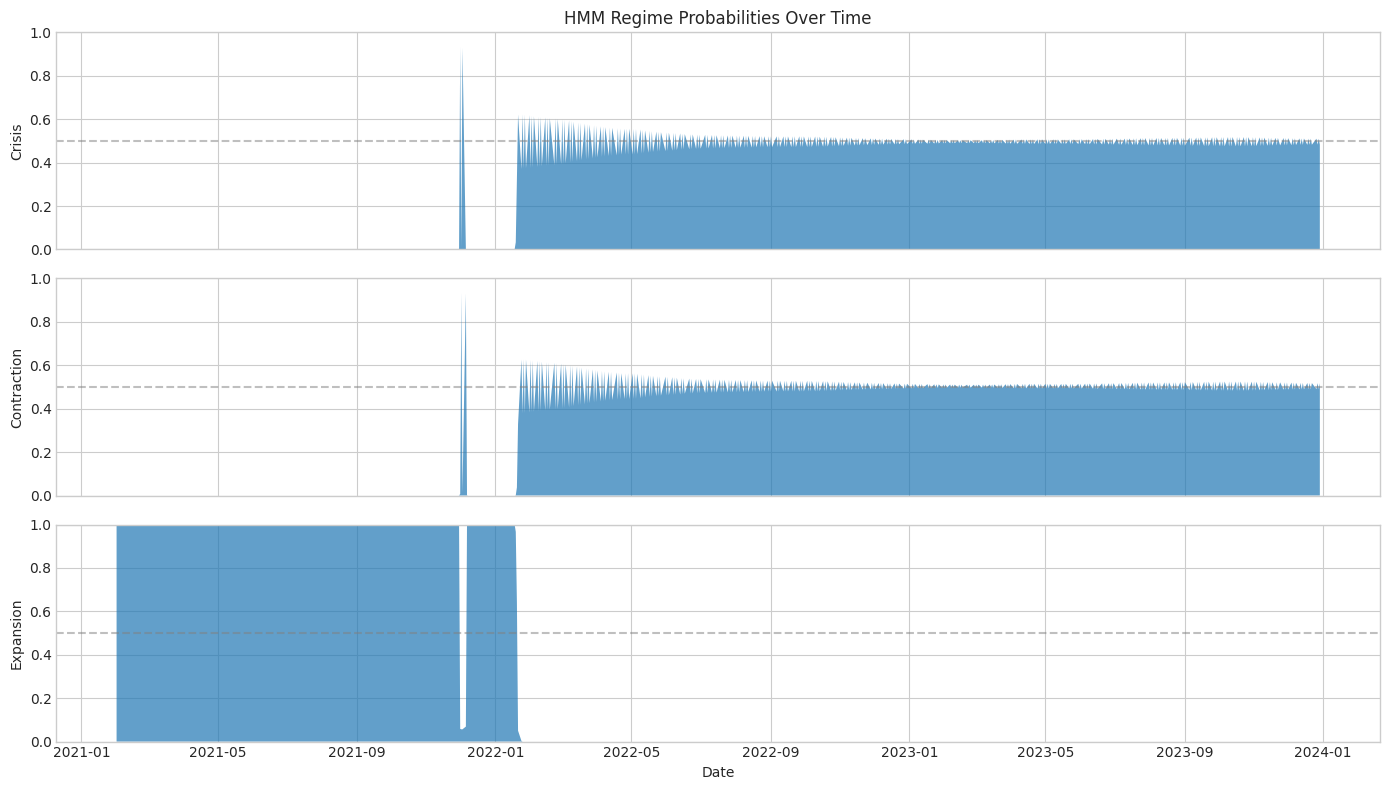

In [10]:
# Get regime probabilities for visualization
hmm_proba = hmm_detector.predict_proba(macro_data)

# Plot regime probabilities over time
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

for i, col in enumerate(hmm_proba.columns):
    axes[i].fill_between(hmm_proba.index, 0, hmm_proba[col], alpha=0.7)
    axes[i].set_ylabel(col.replace('prob_', ''))
    axes[i].set_ylim(0, 1)
    axes[i].axhline(0.5, color='gray', linestyle='--', alpha=0.5)

axes[0].set_title('HMM Regime Probabilities Over Time')
axes[-1].set_xlabel('Date')

plt.tight_layout()
plt.show()

## 4. Compare Rule-Based vs HMM Regimes

Let's visualize both regime classifications overlaid on the price chart.

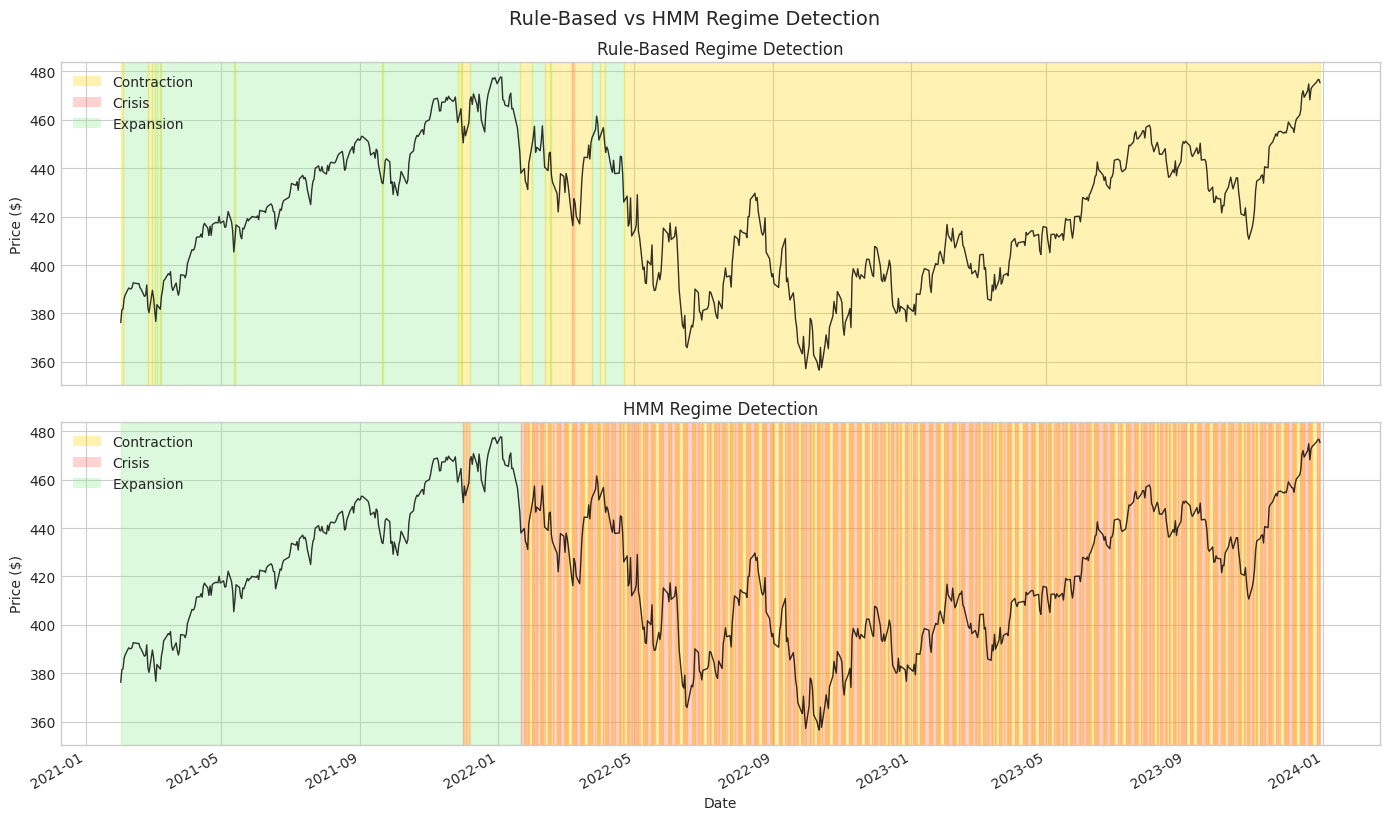

In [11]:
# Get price data for plotting
price_df = data[['Close']].copy()

# Plot comparison
fig = plot_regime_comparison(rule_regimes, hmm_regimes, price_df)
plt.suptitle('Rule-Based vs HMM Regime Detection', fontsize=14, y=1.02)
plt.show()

In [12]:
# Confusion matrix: how well do they agree?
comparison_matrix = rule_detector.compare_with_hmm(macro_data, hmm_regimes)

print("Regime Agreement Matrix (Rule-Based vs HMM):")
print(comparison_matrix)

# Calculate agreement rate
agreement = (rule_regimes == hmm_regimes).mean()
print(f"\nOverall agreement rate: {agreement:.1%}")

Regime Agreement Matrix (Rule-Based vs HMM):
HMM          Contraction  Crisis  Expansion
Rule-Based                                 
Contraction          233     230         12
Crisis                 1       1          0
Expansion             12      15        230

Overall agreement rate: 63.2%


## 5. Regime Transition Analysis

How long do regimes typically last? How often do transitions occur?

In [13]:
# Analyze transitions for rule-based regimes
transition_analysis = analyze_regime_transitions(rule_regimes)

print("Average Regime Duration (days):")
for regime, days in transition_analysis['avg_duration_days'].items():
    print(f"  {regime}: {days:.1f} days")

print("\nTransition Matrix (empirical):")
print(transition_analysis['transition_matrix'].round(3))

Average Regime Duration (days):
  Contraction: 49.4 days
  Crisis: 2.0 days
  Expansion: 30.7 days

Transition Matrix (empirical):
to           Contraction  Crisis  Expansion
from                                       
Contraction        0.973   0.002      0.025
Crisis             0.500   0.500      0.000
Expansion          0.047   0.000      0.953


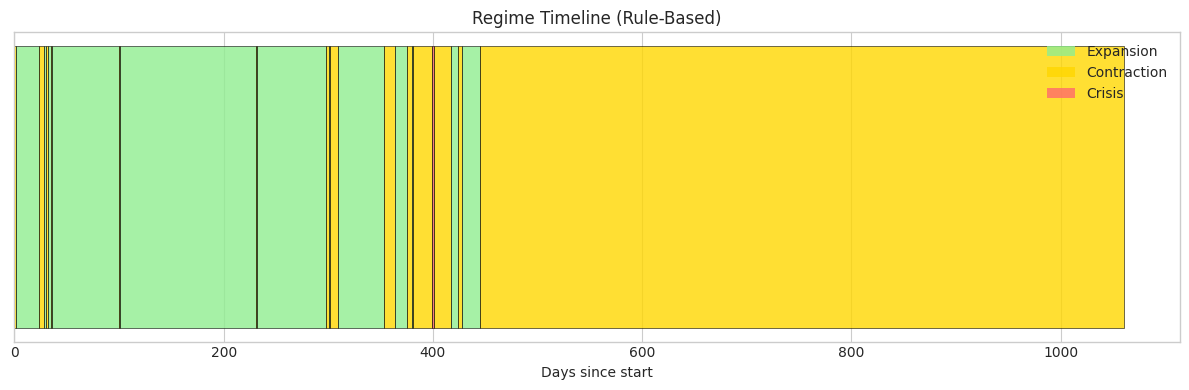

In [14]:
# Visualize regime runs
runs_df = transition_analysis['runs']

fig, ax = plt.subplots(figsize=(12, 4))

regime_colors = {
    'Expansion': '#90EE90',
    'Contraction': '#FFD700',
    'Crisis': '#FF6B6B'
}

for _, run in runs_df.iterrows():
    color = regime_colors.get(run['regime'], 'gray')
    ax.barh(
        y=0,
        width=run['duration_days'],
        left=(run['start'] - runs_df['start'].min()).days,
        height=0.8,
        color=color,
        alpha=0.8,
        edgecolor='black',
        linewidth=0.5
    )

# Legend
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=c, label=r, alpha=0.8) for r, c in regime_colors.items()]
ax.legend(handles=legend_handles, loc='upper right')

ax.set_xlabel('Days since start')
ax.set_yticks([])
ax.set_title('Regime Timeline (Rule-Based)')

plt.tight_layout()
plt.show()

## 6. The Core Hypothesis: Regime-Conditional Correlations

**This is the key test**: Do feature-target correlations become stronger within regimes?

If our hypothesis is correct, we should see:
- Weak overall correlations (as we observed in Milestone 1)
- Stronger correlations within specific regimes
- "Regime lift" > 1 for many features

In [15]:
# Extract features (excluding target and regime)
feature_cols = [c for c in data.columns if c not in ['target', 'forward_return', 'Close']]
features = data[feature_cols].copy()
target = data['target']

# Compute regime-conditional correlations using rule-based regimes
regime_corr = compute_regime_correlations(features, target, rule_regimes)

print("Top 15 Features by Max Regime Correlation:")
print(regime_corr.head(15)[['feature', 'overall_corr', 'Expansion_corr', 'Contraction_corr', 'Crisis_corr', 'max_regime_corr', 'regime_lift']].round(3))

Top 15 Features by Max Regime Correlation:
                     feature  overall_corr  Expansion_corr  Contraction_corr  Crisis_corr  max_regime_corr  regime_lift
0               price_Volume         0.118          -0.014             0.195          NaN            0.195        1.650
34      macro_VIX_percentile        -0.032          -0.170             0.040          NaN            0.170        5.298
27              macro_T10Y2Y         0.044           0.156             0.054          NaN            0.156        3.548
24     price_relative_volume         0.106           0.025             0.151          NaN            0.151        1.420
29              macro_UNRATE         0.067           0.150             0.049          NaN            0.150        2.235
13             price_sma_200        -0.087          -0.135            -0.063          NaN            0.135        1.551
36    macro_UNRATE_change_3m        -0.063          -0.036            -0.130          NaN            0.130        2.0

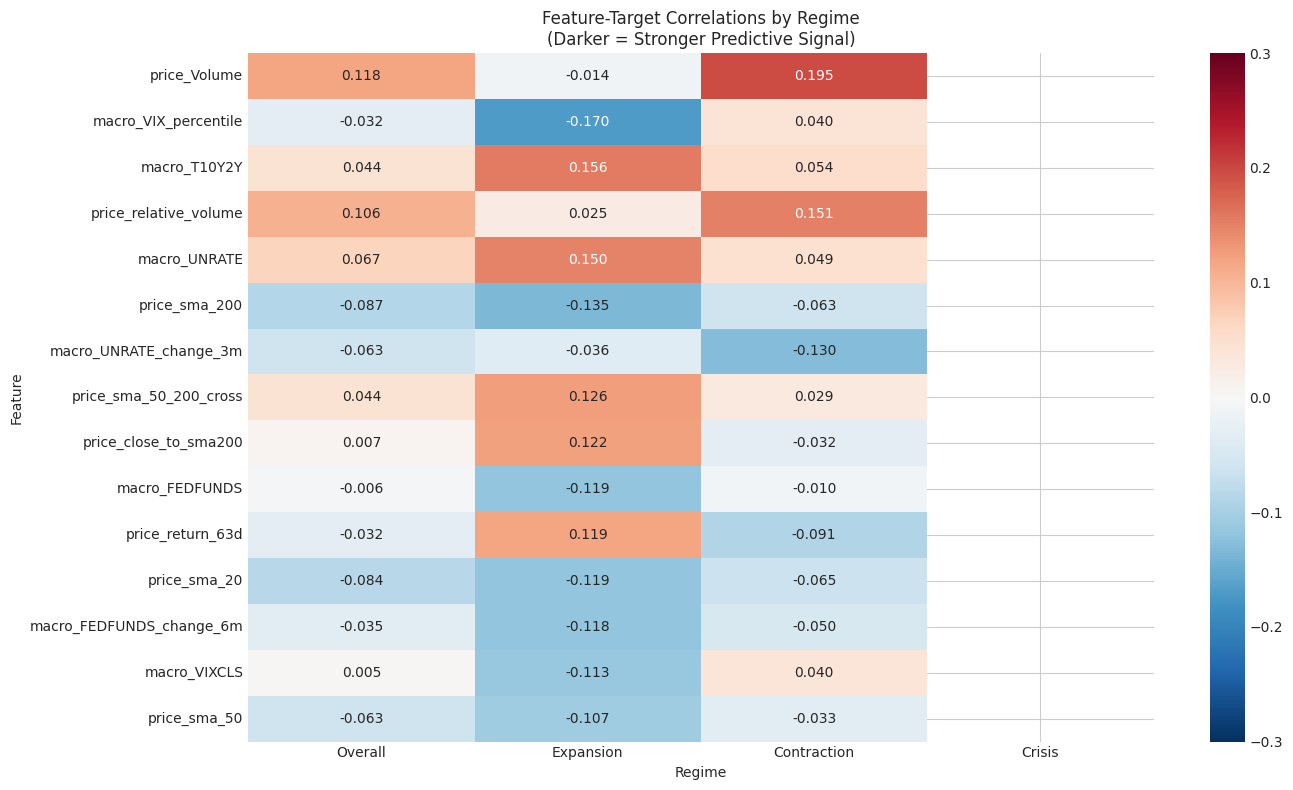

In [16]:
# Visualize correlations by regime
fig, ax = plt.subplots(figsize=(14, 8))

# Select top 15 features
top_features = regime_corr.head(15)

# Prepare data for plotting
corr_cols = ['overall_corr', 'Expansion_corr', 'Contraction_corr', 'Crisis_corr']
plot_data = top_features.set_index('feature')[corr_cols]
plot_data.columns = ['Overall', 'Expansion', 'Contraction', 'Crisis']

# Create heatmap
sns.heatmap(
    plot_data,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-0.3,
    vmax=0.3,
    ax=ax
)

ax.set_title('Feature-Target Correlations by Regime\n(Darker = Stronger Predictive Signal)', fontsize=12)
ax.set_xlabel('Regime')
ax.set_ylabel('Feature')

plt.tight_layout()
plt.show()

In [17]:
# Analyze regime lift
# Regime lift > 1 means correlation is stronger in at least one regime
valid_lift = regime_corr[regime_corr['regime_lift'].notna()]

print(f"Features with regime lift > 1.5: {(valid_lift['regime_lift'] > 1.5).sum()} / {len(valid_lift)}")
print(f"Features with regime lift > 2.0: {(valid_lift['regime_lift'] > 2.0).sum()} / {len(valid_lift)}")
print(f"Average regime lift: {valid_lift['regime_lift'].mean():.2f}")

print("\nTop 10 Features by Regime Lift:")
print(valid_lift.nlargest(10, 'regime_lift')[['feature', 'overall_corr', 'max_regime_corr', 'regime_lift']].round(3))

Features with regime lift > 1.5: 32 / 38
Features with regime lift > 2.0: 25 / 38
Average regime lift: 4.46

Top 10 Features by Regime Lift:
                    feature  overall_corr  max_regime_corr  regime_lift
28             macro_VIXCLS         0.005            0.113       24.779
30           macro_FEDFUNDS        -0.006            0.119       20.481
16    price_close_to_sma200         0.007            0.122       16.887
32   macro_T10Y2Y_change_1m        -0.005            0.048       10.223
9   price_parkinson_vol_21d         0.011            0.081        7.569
7      price_volatility_21d        -0.011            0.077        7.283
8      price_volatility_63d        -0.018            0.104        5.641
34     macro_VIX_percentile        -0.032            0.170        5.298
2           price_return_1d        -0.012            0.062        5.063
6       price_log_return_1d        -0.013            0.063        4.997


## 7. Regime-Specific Performance Analysis

How does market behavior differ across regimes?

In [18]:
# Compute regime statistics
regime_stats = compute_regime_statistics(data, rule_regimes, target_col='target')

print("Regime Statistics:")
print(regime_stats.round(3))

Regime Statistics:
             count  proportion  target_mean  target_std  up_rate
regime                                                          
Contraction    475       0.647        0.341       0.475    0.341
Expansion      257       0.350        0.342       0.475    0.342
Crisis           2       0.003        0.000       0.000    0.000


In [19]:
# Compute actual returns by regime
data_with_regime = data.copy()
data_with_regime['regime'] = rule_regimes

# Daily returns
data_with_regime['daily_return'] = data_with_regime['Close'].pct_change()

# Summarize
regime_returns = data_with_regime.groupby('regime')['daily_return'].agg([
    ('mean_return', 'mean'),
    ('volatility', 'std'),
    ('sharpe', lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0),
    ('min_return', 'min'),
    ('max_return', 'max'),
    ('count', 'count')
])

# Annualize returns
regime_returns['ann_return'] = regime_returns['mean_return'] * 252
regime_returns['ann_volatility'] = regime_returns['volatility'] * np.sqrt(252)

print("\nReturn Statistics by Regime:")
print(regime_returns[['count', 'ann_return', 'ann_volatility', 'sharpe', 'min_return', 'max_return']].round(3))


Return Statistics by Regime:
             count  ann_return  ann_volatility  sharpe  min_return  max_return
regime                                                                        
Contraction    474       0.014           0.198   0.073      -0.043       0.055
Crisis           2      -4.670           0.246 -18.998      -0.029      -0.008
Expansion      257       0.284           0.126   2.255      -0.024       0.024


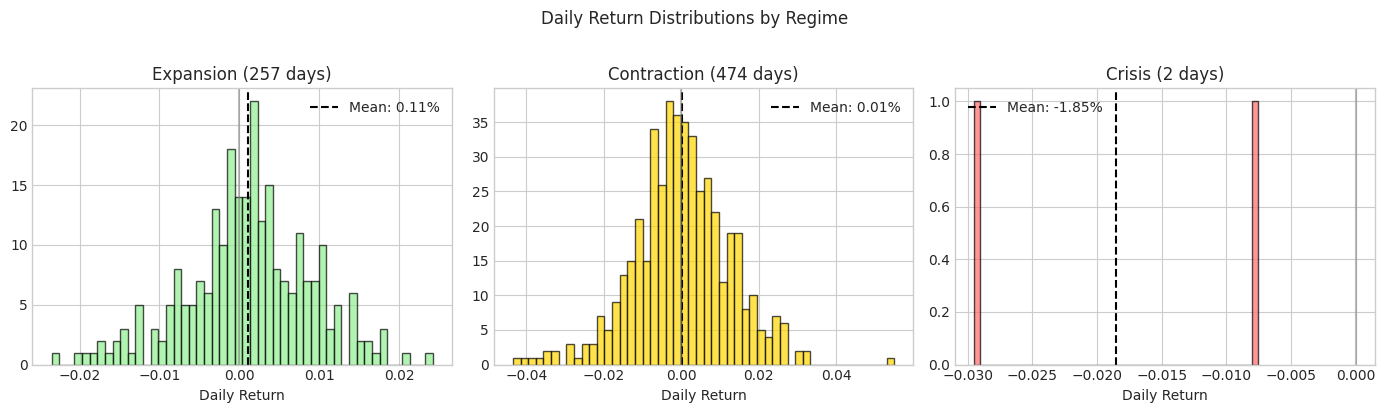

In [20]:
# Visualize return distributions by regime
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

regimes_list = ['Expansion', 'Contraction', 'Crisis']
colors = ['#90EE90', '#FFD700', '#FF6B6B']

for ax, regime, color in zip(axes, regimes_list, colors):
    mask = data_with_regime['regime'] == regime
    returns = data_with_regime.loc[mask, 'daily_return'].dropna()
    
    if len(returns) > 0:
        ax.hist(returns, bins=50, color=color, alpha=0.7, edgecolor='black')
        ax.axvline(returns.mean(), color='black', linestyle='--', label=f'Mean: {returns.mean()*100:.2f}%')
        ax.axvline(0, color='gray', linestyle='-', alpha=0.5)
    
    ax.set_title(f'{regime} ({len(returns)} days)')
    ax.set_xlabel('Daily Return')
    ax.legend()

plt.suptitle('Daily Return Distributions by Regime', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 8. Key Findings Summary

In [21]:
print("=" * 70)
print("MILESTONE 2: REGIME DETECTION - KEY FINDINGS")
print("=" * 70)

print("\n1. REGIME DISTRIBUTION (Rule-Based):")
for regime in ['Expansion', 'Contraction', 'Crisis']:
    count = (rule_regimes == regime).sum()
    pct = count / len(rule_regimes) * 100
    print(f"   {regime}: {count} days ({pct:.1f}%)")

print("\n2. HMM vs RULE-BASED AGREEMENT:")
print(f"   Agreement rate: {agreement:.1%}")

print("\n3. REGIME-CONDITIONAL CORRELATIONS:")
print(f"   Features with regime lift > 1.5: {(valid_lift['regime_lift'] > 1.5).sum()}")
print(f"   Average regime lift: {valid_lift['regime_lift'].mean():.2f}")
top_lift = valid_lift.nlargest(3, 'regime_lift')[['feature', 'regime_lift']]
print(f"   Top features by lift:")
for _, row in top_lift.iterrows():
    print(f"     - {row['feature']}: {row['regime_lift']:.2f}x")

print("\n4. MARKET BEHAVIOR BY REGIME:")
for regime in ['Expansion', 'Contraction', 'Crisis']:
    if regime in regime_returns.index:
        stats = regime_returns.loc[regime]
        print(f"   {regime}:")
        print(f"     Ann. Return: {stats['ann_return']*100:.1f}%")
        print(f"     Ann. Volatility: {stats['ann_volatility']*100:.1f}%")
        print(f"     Sharpe Ratio: {stats['sharpe']:.2f}")

print("\n" + "=" * 70)

MILESTONE 2: REGIME DETECTION - KEY FINDINGS

1. REGIME DISTRIBUTION (Rule-Based):
   Expansion: 257 days (35.0%)
   Contraction: 475 days (64.7%)
   Crisis: 2 days (0.3%)

2. HMM vs RULE-BASED AGREEMENT:
   Agreement rate: 63.2%

3. REGIME-CONDITIONAL CORRELATIONS:
   Features with regime lift > 1.5: 32
   Average regime lift: 4.46
   Top features by lift:
     - macro_VIXCLS: 24.78x
     - macro_FEDFUNDS: 20.48x
     - price_close_to_sma200: 16.89x

4. MARKET BEHAVIOR BY REGIME:
   Expansion:
     Ann. Return: 28.4%
     Ann. Volatility: 12.6%
     Sharpe Ratio: 2.25
   Contraction:
     Ann. Return: 1.4%
     Ann. Volatility: 19.8%
     Sharpe Ratio: 0.07
   Crisis:
     Ann. Return: -467.0%
     Ann. Volatility: 24.6%
     Sharpe Ratio: -19.00



In [22]:
print("Notebook complete!")

Notebook complete!
